In [8]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages 
from langchain_ollama import OllamaLLM
import json

from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel
from langchain_core.pydantic_v1 import Field 
from state import FinanceAgentState
from langgraph.checkpoint.memory import MemorySaver



Import the nodes/workflows  

In [9]:
# individual nodes (need to create separate scripts, defined here for debugging/demo purposes)
from workflows.get_stock_data_and_chart import get_stock_data_and_chart_node
from workflows.get_financial_news import get_financial_news_node
from workflows.curate_report import curate_report_node
from workflows.get_sec_filing_section import get_sec_filing_section_node
from workflows.extract_entities import extract_entities_node


In [10]:


#  1
try:
    llm = OllamaLLM(model="llama3", format="json")
except Exception as e: 
    print(f"Error initialising Ollama. Is the Ollama server running? Error : {e}")



In [11]:

def check_for_chart_keywords(query: str) -> bool:
    """Checks the user query for keywords indicating a chart or plot is requested."""
    query = query.lower()
    return any(keyword in query for keyword in ["chart", "plot", "graph", "visualize"])


# 4 :- intent classification logic 
def classify_intent(state: FinanceAgentState) -> dict:
    """
    This is the "brain" of the application. It uses the LLM in JSON mode
    to classify the user's query into a specific intent.
    """
    print("---NODE: Classifying Intent---")
    user_query = state["user_query"]

    # The prompt now includes format instructions from the parser
    few_shot_prompt = f"""You are an expert at routing a user's query about financial analysis to the correct tool.
Your only job is to return a JSON object with a single key, "step", which indicates the correct tool to use.

The available tools are:
- get_sec_filing_section
- get_financial_news
- get_report
- greeting_help
- get_stock_data_and_chart  

Here are some examples of queries and their correct JSON output:

Queries for "get_sec_filing_section":
- Query: What were the business risks listed in Apple's (AAPL) most recent 10-K?
- JSON: {{"step": "get_sec_filing_section"}}
- Query: Can you get me the "Risk Factors" section from Meta's latest annual report?
- JSON: {{"step": "get_sec_filing_section"}}

Queries for "get_financial_news":
- Query: Summarize recent news about Tesla (TSLA).
- JSON: {{"step": "get_financial_news"}}
- Query: Any recent articles about leadership changes at Johnson & Johnson (JNJ)?
- JSON: {{"step": "get_financial_news"}}

Queries for "get_report":
- Query: Generate a full analyst report for Salesforce (CRM).
- JSON: {{"step": "get_report"}}
- Query: I need a detailed overview of Microsoft's (MSFT) financials and risks.
- JSON: {{"step": "get_report"}}

Queries for "greeting_help":
- Query: Hello, can you help me?
- JSON: {{"step": "greeting_help"}}
- Query: How do I use this?
- JSON: {{"step": "greeting_help"}}

Queries for "get_stock_data_and_chart":
- Query: What is the current P/E ratio for NVIDIA (NVDA)?
- JSON: {{"step": "get_stock_data_and_chart"}}
- Query: Give me a financial summary for Intel (INTC).
- JSON: {{"step": "get_stock_data_and_chart"}}
- Query: Show me a stock chart for Google (GOOGL) over the last year.
- JSON: {{"step": "get_stock_data_and_chart"}}
- Query: Plot the stock performance of Amazon (AMZN) for 2024.
- JSON: {{"step": "get_stock_data_and_chart"}}

---
Now, based on the user's query below, provide the JSON object. You **MUST** only choose from the available tools listed above. If the query does not match any of the tools or is ambiguous, return "{{"step": "greeting_help"}}".

Query: {user_query}
JSON:
"""
    print("---Checking INTENT CLASSIFICATION---")
    response_str = llm.invoke(few_shot_prompt)
    # ----- DEBUG ------ 
    print(f"---LLM RAW OUTPUT:---\n{response_str}\n--------------------")
    
    try:
        # We now use Python's built-in json library to parse the string
        decision_json = json.loads(response_str)
        intent = decision_json["step"]
    except Exception as e:
        # If parsing fails, fall back to a default intent
        print(f"---ERROR: Could not parse LLM output. Error: {e}---\nFalling back to default node - 'greeting_help'")
        intent = "greeting_help"

    updates = {"intent": intent}

    if intent == "get_stock_data_and_chart":
        is_chart_requested = check_for_chart_keywords(user_query)
        updates["create_chart"] = is_chart_requested  
        print(f"---INFO: Chart flag set to {is_chart_requested}---")

    return updates # this will update the State object 

# --- 4. Router Function ---

# main router function 
def route_by_intent(state: FinanceAgentState) -> str:
    """
    Reads the 'intent' from the state and returns the name of the
    next node to run. This is the core of our conditional routing.
    """
    intent = state["intent"]
    print(f"---ROUTING: Intent is '{intent}'---")

    if intent == "get_stock_data_and_chart":
        return "get_stock_data_and_chart"
    elif intent == "get_financial_news":
        return "get_financial_news"
    elif intent == "get_report":
        return "get_stock_data_and_chart_for_report"
    elif intent == "get_sec_filing_section":
        return "get_sec_filing_section"
    else:
        # A fallback in case of an unexpected 
        print("❗Unexpected intent...routing back to continue_or_exit.")
        return "continue_or_exit"

# below are the follow up nodes 

# greeting_help.py

def greeting_help_node(state: FinanceAgentState) -> dict:     # simple greeting 
    
    # --- INSERT THIS LOGIC AT THE END OF EVERY NODE ---
    if state.get("final_answer"):
        print("\n" + state["final_answer"])
        print("-" * 30)
    # --------------------------------------------------
    
    print("---NODE: Providing Greeting/Help---")
    
    instructions = (
        "Hello! I am your personal Financial Analyst Agent 💰📈. "
        "I can fetch data from market sources and SEC filings."
        "\n\nHere are some things you can ask me to do:"
        "\n- Generate a stock performance chart for **Amazon (AMZN)**."
        "\n- What are the **risks** listed in **Microsoft's latest 10-K** filing?"
        "\n- Summarize recent **news** about **Tesla (TSLA)**."
        "\n- What is the current **P/E ratio** for **NVIDIA (NVDA)**?"
        "\n- **Generate a full analyst report** for **Salesforce (CRM)**."
    )


    
    return {"final_answer": instructions}

def continue_or_exit_node(state: FinanceAgentState) -> dict:
    """
    Prompts the user for the next query, capturing input, and setting the
    'should_continue' flag for the 'follow_up_router'.
    """

        # --- ADDED LOGIC: Display the message from the previous node (the greeting) ---
    if state.get("final_answer"):
        print("\n" + state["final_answer"])
        print("-" * 30)
    # -----------------------------------------------------------------------------

    print("\n--- Awaiting Next Query ---")
    while True:
        user_input = input(" -> Your Question (or type 'exit' to quit): ")
        
        if user_input.lower() == 'exit':
            # 1. Signals the 'follow_up_router' to route to END.
            return {"should_continue": False}
        else:
            # 2. Signals 'follow_up_router' to continue AND updates the state 
            #    with the new query for the next classification step.
            return {"user_query": user_input, "should_continue": True}


# follow-up router function 
def route_follow_up1(state: FinanceAgentState) -> str:
    """
    Reads the 'should_continue' flag from the state and returns the
    next node to run. Routes directly to extract_entities for the next turn.
    """
    should_continue = state["should_continue"]
    
    print(f"---FOLLOW-UP ROUTING: ", 
          f"\nUser wants to continue = '{should_continue}'" if should_continue else "\nUser wants to EXIT = '{should_continue}'", 
          "---")

    if should_continue:
        return "extract_entities"
    else:
        # Correct: Terminates the graph execution.
        return END

# follow-up router function 
def route_follow_up2(state: FinanceAgentState) -> str:
    """
    Reads the 'should_continue' flag from the state and returns the
    next node to run. Routes directly to greeting_help for the next turn.
    """
    should_continue = state["should_continue"]
    
    print(f"---FOLLOW-UP ROUTING: ", 
          f"\nUser wants to continue = '{should_continue}'" if should_continue else "\nUser wants to EXIT = '{should_continue}'", 
          "---")

    if should_continue:
        return "extract_entities"
    else:
        # Correct: Terminates the graph execution.
        return END
    

# --- 5. Graph Definition and Compilation ---

# Initialize the state graph
graph_builder = StateGraph(FinanceAgentState)


# Add all the nodes to the graph with consistent names
graph_builder.add_node("greeting_help", greeting_help_node)
graph_builder.add_node("continue_or_exit1", continue_or_exit_node)  # use router1
graph_builder.add_node("extract_entities", extract_entities_node)  
graph_builder.add_node("classify_intent", classify_intent)
graph_builder.add_node("get_stock_data_and_chart", get_stock_data_and_chart_node)
graph_builder.add_node("get_financial_news", get_financial_news_node)
graph_builder.add_node("get_sec_filing_section", get_sec_filing_section_node)


# get report 
graph_builder.add_node("get_stock_data_and_chart_for_report", get_stock_data_and_chart_node)
graph_builder.add_node("get_financial_news_for_report", get_financial_news_node)
graph_builder.add_node("get_sec_filing_section_for_report", get_sec_filing_section_node)
graph_builder.add_node("curate_report", curate_report_node)
graph_builder.add_node("continue_or_exit2", continue_or_exit_node)  # use router 2 

# orchestrate

# Set the entry point of the graph
# graph_builder.set_entry_point("greeting_help")
graph_builder.add_edge(START, "greeting_help")

# Add the conditional edge for routing.
# This tells the graph: after 'classify_intent', call 'route_by_intent'
# to decide which node to go to next.

graph_builder.add_edge("greeting_help", "continue_or_exit1")
graph_builder.add_conditional_edges(
    "continue_or_exit1",
    route_follow_up1,
)

graph_builder.add_edge("extract_entities", "classify_intent")
graph_builder.add_conditional_edges(
    "classify_intent",
    route_by_intent,
)

graph_builder.add_edge("get_stock_data_and_chart", "continue_or_exit2")
graph_builder.add_edge("get_financial_news", "continue_or_exit2")
graph_builder.add_edge("get_sec_filing_section", "continue_or_exit2")

# graph_builder.add_edge("get_report", "get_stock_data_and_chart_for_report")
graph_builder.add_edge("get_stock_data_and_chart_for_report", "get_financial_news_for_report")
graph_builder.add_edge("get_financial_news_for_report", "get_sec_filing_section_for_report")
graph_builder.add_edge("get_sec_filing_section_for_report", "curate_report")
graph_builder.add_edge("curate_report", "continue_or_exit2")


graph_builder.add_conditional_edges(
    "continue_or_exit2", 
    route_follow_up2,
  )

# app = graph_builder.compile(checkpointer=memory)
app = graph_builder.compile()


In [12]:

from IPython.display import Image, display
# from langchain_core.runnables.graph import MermaidDrawMethod
# ...
try:
    print(display(Image(app.get_graph().draw_mermaid_png())))
except Exception as e:
    print(f"Could not display graph. Error: {e}")


Could not display graph. Error: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


Could not display graph. Error: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

Starting Financial Agent.
---NODE: Providing Greeting/Help---

Hello! I am your personal Financial Analyst Agent 💰📈. I can fetch data from market sources and SEC filings.

Here are some things you can ask me to do:
- Generate a stock performance chart for **Amazon (AMZN)**.
- What are the **risks** listed in **Microsoft's latest 10-K** filing?
- Summarize recent **news** about **Tesla (TSLA)**.
- What is the current **P/E ratio** for **NVIDIA (NVDA)**?
- **Generate a full analyst report** for **Salesforce (CRM)**.
------------------------------

--- Awaiting Next Query ---
---FOLLOW-UP ROUTING:  
User wants to continue = 'True' ---

Hello! I am your personal Financial Analyst Agent 💰📈. I can fetch data from market sources and SEC filings.

Here are some things you can ask me to do:
- Generate a stock performance chart for **Amazon (AMZN)**.
- What are the **risks** listed in **Microsoft's latest 10-K** filing?
- Summarize recent **news** about **Tesla (TSLA)**.
- What is the current **

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔄 NODE: Generating Professional Analyst Report                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

============================================================

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                      📊 Financial Analyst Report for Apple                                      ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                 Executive Summary                                                 

This report combines key insights from market data, SEC filings, and news sentiment.                               


                                               1. Key Business Risks                                               

Based on the company's most recent SEC filing: None                                                                


                                      2. Recent Market Performance (Summary)                                       

Current Price: $252.31 | Market Cap: $3,744,378,650,624 | P/E Ratio: 38.286797                                     


                                            3. Recent News & Catalysts                                             

An analysis of recent financial news reveals the following events:                                                 

 • iPhone 17 Pro review: A power house without functional compromise                                               
 • The CEO Playbook: Proven Business Growth Strategies To Scale Your EdTech Company                                

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Generated: September 25, 2025 at 06:33 PM Note: This report is for informational purposes only.

============================================================

c:\Desktop\coding\Agents\financial_analyst_langgraph\workflows\curate_report.py:364: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date, progress=False)


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ ⚠️ Chart creation failed: 'y1' is not 1-dimensional                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ ⚠️ DOCX save failed: 'NoneType' object has no attribute 'set'                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

---NODE: Displaying Report in Markdown---



# 📊 Financial Analyst Report for Apple

## Executive Summary
This report combines key insights from market data, SEC filings, and news sentiment.

## 1. Key Business Risks
Based on the company's most recent SEC filing:
None

## 2. Recent Market Performance (Summary)
Current Price: **$252.31** | Market Cap: **$3,744,378,650,624** | P/E Ratio: **38.286797**

## 3. Recent News & Catalysts
An analysis of recent financial news reveals the following events:
- **iPhone 17 Pro review: A power house without functional compromise**
- **The CEO Playbook: Proven Business Growth Strategies To Scale Your EdTech Company**

---

**Generated:** September 25, 2025 at 06:33 PM
**Note:** This report is for informational purposes only.




# 📊 Financial Analyst Report for Apple

## Executive Summary
This report combines key insights from market data, SEC filings, and news sentiment.

## 1. Key Business Risks
Based on the company's most recent SEC filing:
None

## 2. Recent Market Performance (Summary)
Current Price: **$252.31** | Market Cap: **$3,744,378,650,624** | P/E Ratio: **38.286797**

## 3. Recent News & Catalysts
An analysis of recent financial news reveals the following events:
- **iPhone 17 Pro review: A power house without functional compromise**
- **The CEO Playbook: Proven Business Growth Strategies To Scale Your EdTech Company**

---

**Generated:** September 25, 2025 at 06:33 PM
**Note:** This report is for informational purposes only.

------------------------------

--- Awaiting Next Query ---
---FOLLOW-UP ROUTING:  
User wants to continue = 'True' ---


# 📊 Financial Analyst Report for Apple

## Executive Summary
This report combines key insights from market data, SEC filings, and news sentiment.

## 

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔄 NODE: Generating Professional Analyst Report                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

============================================================

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                      📊 Financial Analyst Report for Apple                                      ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                 Executive Summary                                                 

This report combines key insights from market data, SEC filings, and news sentiment.                               


                                               1. Key Business Risks                                               

Based on the company's most recent SEC filing: None                                                                


                                      2. Recent Market Performance (Summary)                                       

Current Price: $252.31 | Market Cap: $3,744,378,650,624 | P/E Ratio: 38.286797                                     


                                            3. Recent News & Catalysts                                             

An analysis of recent financial news reveals the following events:                                                 

 • iPhone 17 Pro review: A power house without functional compromise                                               
 • The CEO Playbook: Proven Business Growth Strategies To Scale Your EdTech Company                                

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Generated: September 25, 2025 at 06:33 PM Note: This report is for informational purposes only.

============================================================

c:\Desktop\coding\Agents\financial_analyst_langgraph\workflows\curate_report.py:364: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date, progress=False)


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ ⚠️ Chart creation failed: 'y1' is not 1-dimensional                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ ⚠️ DOCX save failed: 'NoneType' object has no attribute 'set'                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

---NODE: Displaying Report in Markdown---



# 📊 Financial Analyst Report for Apple

## Executive Summary
This report combines key insights from market data, SEC filings, and news sentiment.

## 1. Key Business Risks
Based on the company's most recent SEC filing:
None

## 2. Recent Market Performance (Summary)
Current Price: **$252.31** | Market Cap: **$3,744,378,650,624** | P/E Ratio: **38.286797**

## 3. Recent News & Catalysts
An analysis of recent financial news reveals the following events:
- **iPhone 17 Pro review: A power house without functional compromise**
- **The CEO Playbook: Proven Business Growth Strategies To Scale Your EdTech Company**

---

**Generated:** September 25, 2025 at 06:33 PM
**Note:** This report is for informational purposes only.




# 📊 Financial Analyst Report for Apple

## Executive Summary
This report combines key insights from market data, SEC filings, and news sentiment.

## 1. Key Business Risks
Based on the company's most recent SEC filing:
None

## 2. Recent Market Performance (Summary)
Current Price: **$252.31** | Market Cap: **$3,744,378,650,624** | P/E Ratio: **38.286797**

## 3. Recent News & Catalysts
An analysis of recent financial news reveals the following events:
- **iPhone 17 Pro review: A power house without functional compromise**
- **The CEO Playbook: Proven Business Growth Strategies To Scale Your EdTech Company**

---

**Generated:** September 25, 2025 at 06:33 PM
**Note:** This report is for informational purposes only.

------------------------------

--- Awaiting Next Query ---
---FOLLOW-UP ROUTING:  
User wants to EXIT = '{should_continue}' ---

--- Session Ended ---


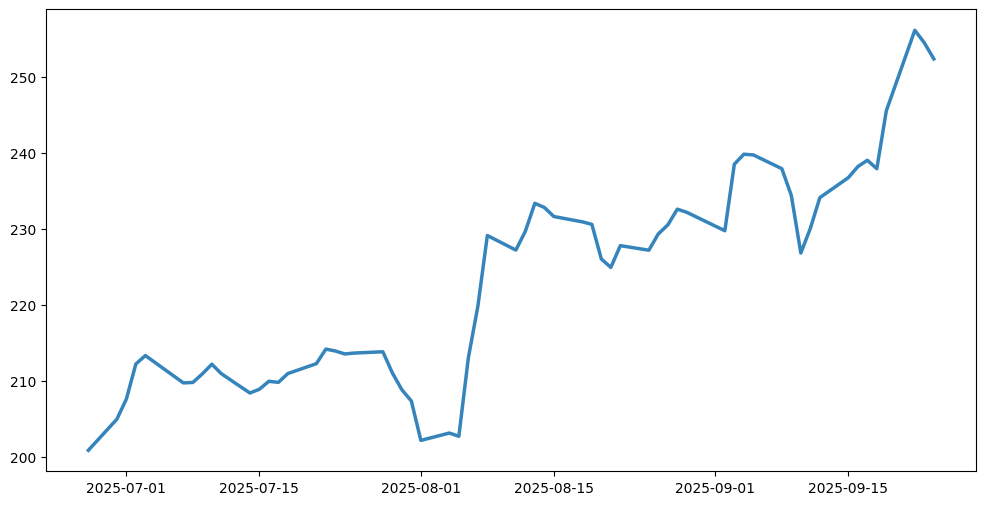

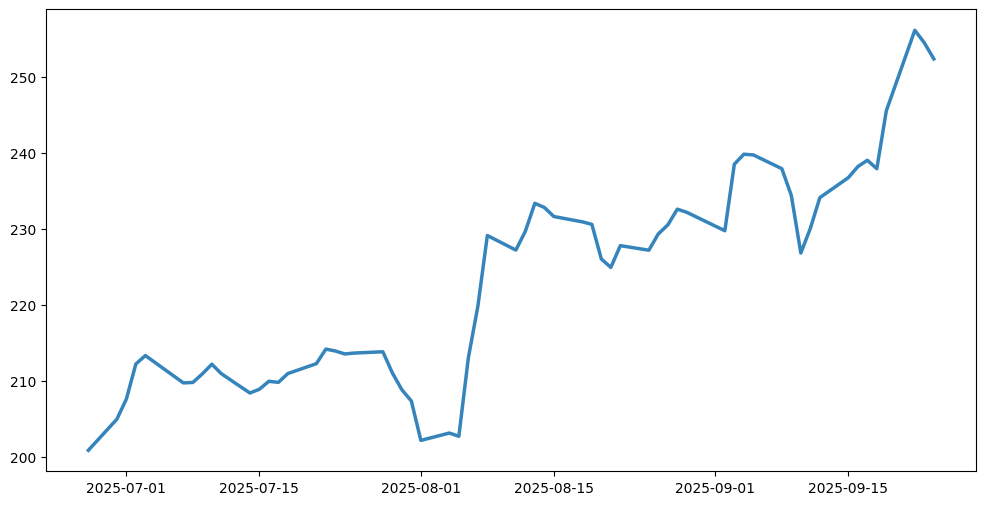

In [13]:
if __name__ == "__main__":
    
    # 1. Prepare the initial state
    initial_state = {
        "user_query": None, # The initial state starts with no query
        "messages": [],
        "should_continue": True, # Always True to force the very first execution
        "create_chart": False,
        "company_name": None,
        "ticker": None,
        "filing_type": None,
        "section": None,
        "tool_result": None,
        "structured_data": None,
        "final_answer": None,
        "report_data": None,
        "price_history_json": None,
        "news_results": None,
    }
    
    # 2. Run the full conversational loop until the user types 'exit'
    
    # NOTE: The loop starts here and relies on the 'continue_or_exit' nodes
    #       to prompt the user and update the state for the next turn.
    
    # First, invoke the graph with a single turn to get the conversation started (The Greeting/Input)
    print("Starting Financial Agent.")
    current_state = app.invoke(initial_state)

    # Now, enter the continuous loop
    while current_state.get("should_continue", False):
        try:
            # The current_state contains the final_answer from the previous step.
            # We print the result *before* the next turn starts.
            print(f"\nFinal Answer: {current_state['final_answer']}")
            print("-" * 30)

            # Invoke the graph again. This will hit the continue_or_exit node,
            # wait for user input, update the state, and proceed with the new query.
            current_state = app.invoke(current_state)
            
        except Exception as e:
            print(f"\nFATAL ERROR DURING LOOP: {e}")
            break
            
    # Final cleanup message
    print("\n--- Session Ended ---")

In [14]:
# # Assuming 'app' is the compiled graph instance

# # 1. Define the hardcoded query you want to execute
# TEST_QUERY = "What is the current P/E ratio for NVIDIA (NVDA) and show me a chart." 

# # 2. Define the initial state (use your existing structure)
# initial_state = {
#     # Initialize all keys to prevent KeyError
#     "user_query": TEST_QUERY, # <-- The query is set here
#     "messages": [],
#     "intent": None, 
#     "should_continue": True,
#     "create_chart": False,
#     "company_name": None,
#     "ticker": None,
#     "filing_type": None,
#     "section": None,
#     "tool_result": None,
#     "structured_data": None,
#     "final_answer": None,
#     "report_data": None,
#     "price_history_json": None,
#     "news_results": None,
# }

# # 3. Invoke the graph (your existing call, but without the input() prompt)
# print(f"--- Executing Agent with Query: '{TEST_QUERY}' ---")
# final_state = app.invoke(initial_state)

# # 4. The graph will run the following sequence automatically:
# #    START -> classify_intent -> extract_entities -> get_stock_data_and_chart -> END

# print(f"\nFinal Answer: {final_state['final_answer']}")
# print("-" * 30)